<a href="https://colab.research.google.com/github/minhdinh03/FlowerClassificationProject/blob/main/Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, losses, Model
from typing import Tuple
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, ZeroPadding2D,\
     Flatten, BatchNormalization, AveragePooling2D, Dense, Activation, Add, AvgPool2D, GlobalAveragePooling2D, MaxPool2D 
from tensorflow.keras.models import Model
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import ReLU, concatenate
import tensorflow.keras.backend as K
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
import seaborn as sns

os.environ["cuda_visible_devices"]="0" 

from glob import glob
import io
from PIL import Image

import math, re, os
import numpy as np
import pandas as pd
from collections import Counter

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.8.0


In [ ]:
if tf.test.gpu_device_name(): 

    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

In [ ]:
IMAGE_SIZE = [224, 224]
PATH = '/content/drive/MyDrive/Colab_Notebooks/combined_data_splitted'
MODEL_PATH = '/content/drive/MyDrive/Colab_Notebooks/Models'
MODELS = ["GooGleNet", "Random", "ResNet50", "DenseNet121", "Baseline"]
AUTO = tf.data.experimental.AUTOTUNE


TEST_PATH = tf.io.gfile.glob(PATH + '/test/*.tfrecord')
TRAIN_PATH = tf.io.gfile.glob(PATH + '/train/*.tfrecord')
VAL_PATH = tf.io.gfile.glob(PATH + '/validation/*.tfrecord')
GOOGLENET = MODEL_PATH + '/GoogleNet'
RANDOMMODEL = MODEL_PATH + '/RandomModel'
RESNET = MODEL_PATH + '/ResNet'
DENSENET = MODEL_PATH + '/DenseNet'


In [ ]:
CLASSES = ['pink primrose',
 'wild geranium',
 'spear thistle',
 'yellow iris',
 'wallflower',
 'buttercup',
 'daisy',
 'common dandelion',
 'petunia',
 'sunflower',
 'iris',
 'windflower',
 'water lily',
 'rose',
 'morning glory',
 'frangipani',
 'cyclamen ',
 'foxglove',
 'common tulip',
 'wild rose']


In [ ]:

def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs


def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

In [ ]:
def get_test_dataset(path = TEST_PATH):
    #we wont batch it for ease of making graphs
    dataset = load_dataset(path)
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_training_dataset(path = TRAIN_PATH, labeled = True):
    dataset = load_dataset(path)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(path = VAL_PATH):
    dataset = load_dataset(path)
    dataset = dataset.prefetch(AUTO)
    return dataset

In [ ]:
def load_model(path):
    return tf.keras.models.load_model(path)

In [ ]:
ds_test = get_test_dataset()

google_net = load_model(GOOGLENET)
random_model = load_model(RANDOMMODEL)
resnet = load_model(RESNET)
densenet = load_model(DENSENET)

In [ ]:
ds_train = get_training_dataset()
ds_val = get_validation_dataset()

In [ ]:

y_train = ds_train.map(lambda x, y: y)

y_val = ds_val.map(lambda x, y: y)

In [ ]:
x_test = ds_test.map(lambda x, y: x)
y_test = ds_test.map(lambda x, y: y)

In [ ]:
#batch after splitting
ds_test = ds_test.batch(251)

In [ ]:
#Accuracy and its confidence interval

In [ ]:
acc_gnet = google_net.evaluate(ds_test, batch_size = 251)[4]

6/6 [==============================] - 51s 8s/step - loss: 1.9804 - dense_4_loss: 1.2370 - dense_1_loss: 1.2362 - dense_3_loss: 1.2420 - dense_4_accuracy: 0.5869 - dense_1_accuracy: 0.6065 - dense_3_accuracy: 0.6109


In [ ]:
acc_random_model = random_model.evaluate(ds_test, batch_size = 251)[1]

6/6 [==============================] - 17s 3s/step - loss: 1.6309 - accuracy: 0.4916


In [ ]:
acc_resnet = resnet.evaluate(ds_test, batch_size = 251)[1]

6/6 [==============================] - 219s 36s/step - loss: 1.9233 - accuracy: 0.5091


In [ ]:
acc_densenet = densenet.evaluate(ds_test, batch_size = 251)[1]

6/6 [==============================] - 200s 32s/step - loss: 0.8924 - accuracy: 0.7004


In [ ]:
acc_baseline = 154/1375

In [ ]:
accuracy = [acc_gnet, acc_random_model, acc_resnet, acc_densenet, acc_baseline]
z = 1.96 #0.95 CI
n_sample = 1375

In [ ]:
ci_gnet = z * math.sqrt( (acc_gnet * (1 - acc_gnet)) / n_sample)
ci_rand = z * math.sqrt( (acc_random_model * (1 - acc_random_model)) / n_sample)
ci_resnet = z * math.sqrt( (acc_resnet * (1 - acc_resnet)) / n_sample)
ci_densenet = z * math.sqrt( (acc_densenet * (1 - acc_densenet)) / n_sample)
ci_baseline = z * math.sqrt( (acc_baseline * (1 - acc_baseline)) / n_sample)
ci_interval = [ci_gnet, ci_rand, ci_resnet, ci_densenet, ci_baseline]

In [ ]:
acc_result = {}
for i in range(5):
    acc_result[MODELS[i]] = f"{accuracy[i]} +- {ci_interval[i]}"
acc_result

{'Baseline': '0.112 +- 0.016669409535269852',
 'DenseNet121': '0.7003636360168457 +- 0.02421384599201461',
 'GooGleNet': '0.5869091153144836 +- 0.026026331403296583',
 'Random': '0.49163636565208435 +- 0.026424936963847973',
 'ResNet50': '0.5090909004211426 +- 0.026424265886453732'}

Text(0.5, 1.0, 'Accuracy with 95% confidence interval')

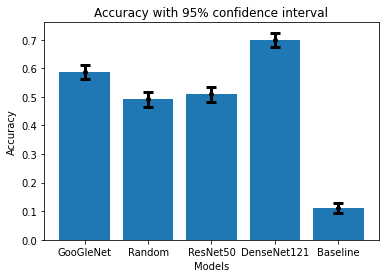

In [ ]:
plt.errorbar( MODELS, accuracy, ci_interval, fmt='o', color='Black', elinewidth=3,capthick=3,errorevery=1, alpha=1, ms=4, capsize = 5)
plt.bar(MODELS, accuracy,tick_label = MODELS)##Bar plot
plt.xlabel('Models') ## Label on X axis
plt.ylabel('Accuracy') ##Label on Y axis
plt.title('Accuracy with 95% confidence interval')

In [ ]:
x_test = np.stack(list(x_test))
y_test = np.stack(list(y_test))

In [ ]:

y_train = np.stack(list(y_train))

y_val = np.stack(list(y_val))

In [ ]:
list_test = y_test.tolist()

In [ ]:
list_train = y_train.tolist()
list_val = y_val.tolist()

In [ ]:
values_test, counts_test = np.unique(list_test, return_counts=True)
values_train, counts_train = np.unique(list_train, return_counts=True)
values_val, counts_val = np.unique(list_val, return_counts=True)


In [ ]:
print(f"train: {sum(counts_train)}")
print(f"validation: {sum(counts_val)}")
print(f"test: {sum(counts_test)}")

train: 6409
validation: 1373
test: 1375


In [ ]:
test_set = {}
for value_test in values_test:
  test_set[CLASSES[value_test]] = counts_test[value_test]

In [ ]:
val_set = {}
for value_val in values_val:
  val_set[CLASSES[value_val]] = counts_val[value_val]

In [ ]:
train_set = {}
for value_train in values_train:
  train_set[CLASSES[value_train]] = counts_train[value_train]

In [ ]:
dataset_nested = {}
dataset_nested["train"] = train_set
dataset_nested["val"] = val_set
dataset_nested["test"] = test_set

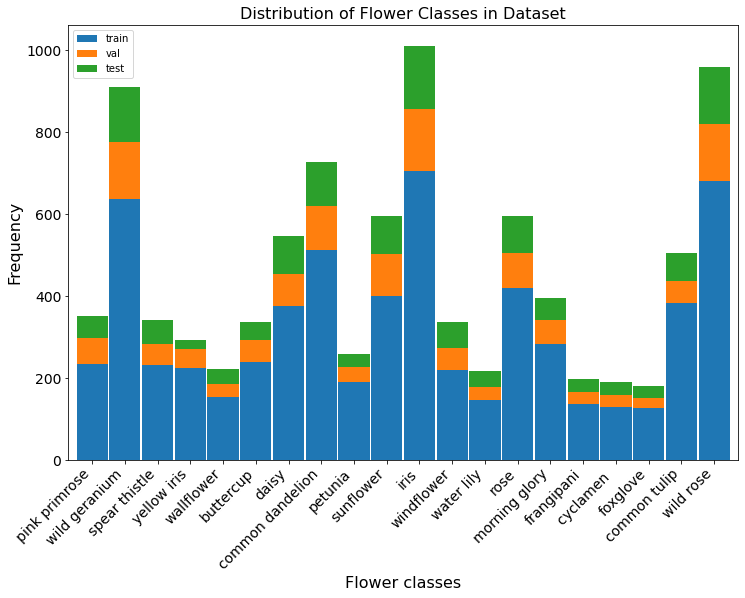

In [ ]:

df = pd.DataFrame(dataset_nested)
ax1 = df.plot(figsize=(12,8), kind="bar", stacked=True, width=0.95)
plt.xticks(fontsize=14, rotation=45, ha="right")
plt.yticks(fontsize=14)

plt.xlabel("Flower classes", fontsize = 16)
plt.ylabel("Frequency", fontsize = 16)
plt.title("Distribution of Flower Classes in Dataset", fontdict = {"fontsize" : 16})
plt.show()

In [ ]:
y_pred_dense = densenet.predict(x_test)
#from probability to class
y_pred_dense = np.argmax(y_pred_dense, axis = 1)

In [ ]:
y_pred_res = resnet.predict(x_test)
#from probability to class
y_pred_res = np.argmax(y_pred_res, axis = 1)

In [ ]:
y_pred_google = google_net.predict(x_test)[0]
#from probability to class
y_pred_google = np.argmax(y_pred_google, axis = 1)

In [ ]:
y_pred_rand = random_model.predict(x_test)
#from probability to class
y_pred_rand = np.argmax(y_pred_rand, axis = 1)

In [ ]:
y_pred_base = [10 for x in range(1375)]

In [ ]:
# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, ax, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(CLASSES):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        # ax.plot(fpr, tpr, label = '%s'  % (c_label))
        ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    ax.plot(fpr, fpr, 'b-', label = 'Baseline')
    return roc_auc_score(y_test, y_pred, average=average)

ROC AUC score of DenseNet121: 0.8290514337571773
ROC AUC score of ResNet50: 0.712951242970753
ROC AUC score of GooGleNet: 0.7501611278799818
ROC AUC score of Random Model: 0.693781822098461


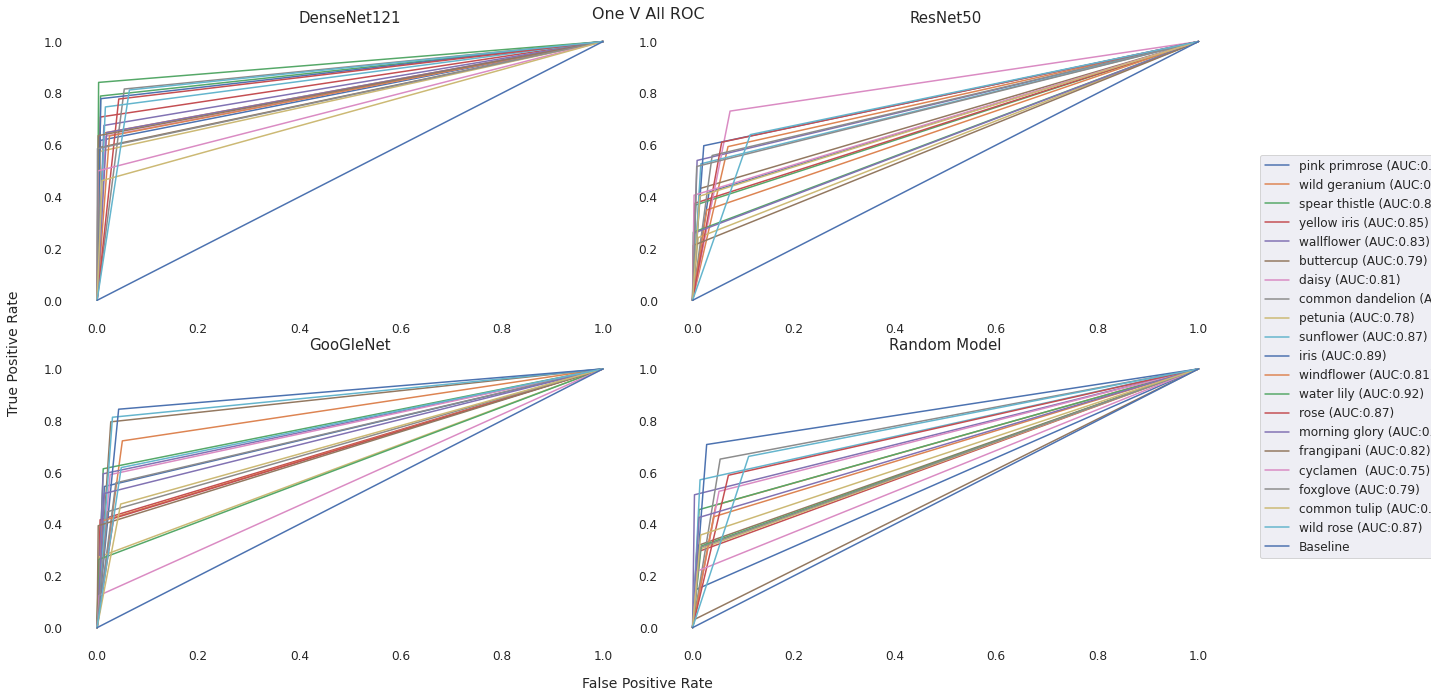

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (20, 10))
print('ROC AUC score of DenseNet121:', multiclass_roc_auc_score(y_test, y_pred_dense, ax1))
# ax1.set_xlabel('False Positive Rate', labelpad=-2.5)
# ax1.set_ylabel('True Positive Rate', labelpad=-4)
ax1.set_title('DenseNet121', {'fontsize' : 15})
print('ROC AUC score of ResNet50:', multiclass_roc_auc_score(y_test, y_pred_res, ax2))
# ax2.set_xlabel('False Positive Rate', labelpad=-2.5)
# ax2.set_ylabel('True Positive Rate', labelpad=-4)
ax2.set_title('ResNet50', {'fontsize' : 15})
print('ROC AUC score of GooGleNet:', multiclass_roc_auc_score(y_test, y_pred_google, ax3))
# ax3.set_xlabel('False Positive Rate', labelpad=-2.5)
# ax3.set_ylabel('True Positive Rate', labelpad=-4)
ax3.set_title('GooGleNet', {'fontsize' : 15})
print('ROC AUC score of Random Model:', multiclass_roc_auc_score(y_test, y_pred_rand, ax4))
# ax4.set_xlabel('False Positive Rate', labelpad=-2.5)
# ax4.set_ylabel('True Positive Rate', labelpad=-4)
ax4.set_title('Random Model', {'fontsize' : 15})
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc = (0.88, 0.2))
plt.suptitle("One V All ROC", fontdict = {'fontsize' : 15})
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.95, 
                    wspace=0.07, 
                    hspace=0.15)
fig.text(0.5, 0.04, 'False Positive Rate', ha='center', va='center', fontsize = 14)
fig.text(0.06, 0.5, 'True Positive Rate', ha='center', va='center', rotation='vertical', fontsize = 14)
plt.show()

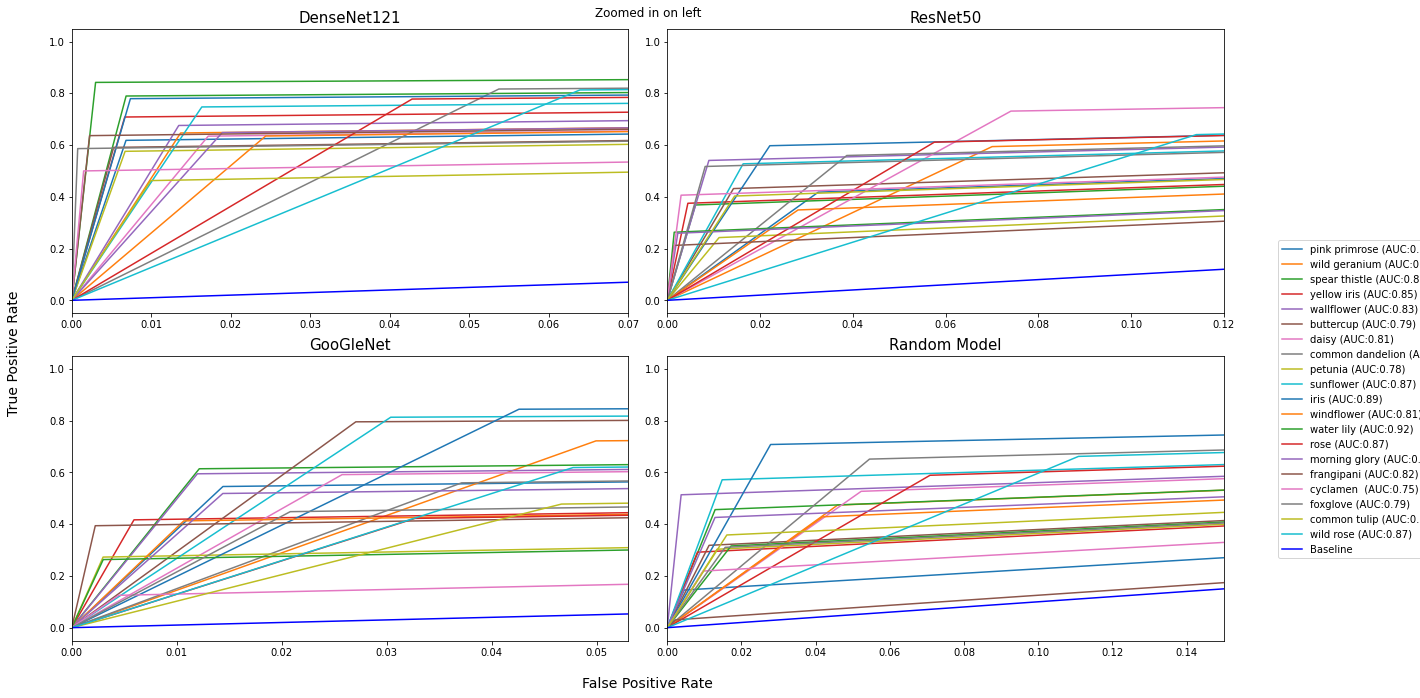

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (20, 10))

multiclass_roc_auc_score(y_test, y_pred_dense, ax1)
# ax1.legend(fontsize = 5)
ax1.set_xlim([0,0.07])
ax1.set_title('DenseNet121', {'fontsize' : 15})
multiclass_roc_auc_score(y_test, y_pred_res, ax2)
# ax2.legend()
ax2.set_xlim([0,0.12])
ax2.set_title('ResNet50', {'fontsize' : 15})
multiclass_roc_auc_score(y_test, y_pred_google, ax3)
# ax3.legend()
ax3.set_xlim([0,0.053])
ax3.set_title('GooGleNet', {'fontsize' : 15})
multiclass_roc_auc_score(y_test, y_pred_rand, ax4)
# ax4.legend()
ax4.set_xlim([0,0.15])
ax4.set_title('Random Model', {'fontsize' : 15})
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc = (0.9, 0.2))
plt.suptitle("Zoomed in on left", fontdict = {'fontsize' : 30})
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.95, 
                    wspace=0.07, 
                    hspace=0.15)
fig.text(0.5, 0.04, 'False Positive Rate', ha='center', va='center', fontsize = 14)
fig.text(0.06, 0.5, 'True Positive Rate', ha='center', va='center', rotation='vertical', fontsize = 14)
                    
plt.show()


In [ ]:
conf_matrix_dense = tf.math.confusion_matrix(y_test, y_pred_dense)
conf_matrix_res = tf.math.confusion_matrix(y_test, y_pred_res)
conf_matrix_google = tf.math.confusion_matrix(y_test, y_pred_google)
conf_matrix_rand = tf.math.confusion_matrix(y_test, y_pred_rand)
conf_matrix_base = tf.math.confusion_matrix(y_test, y_pred_base)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


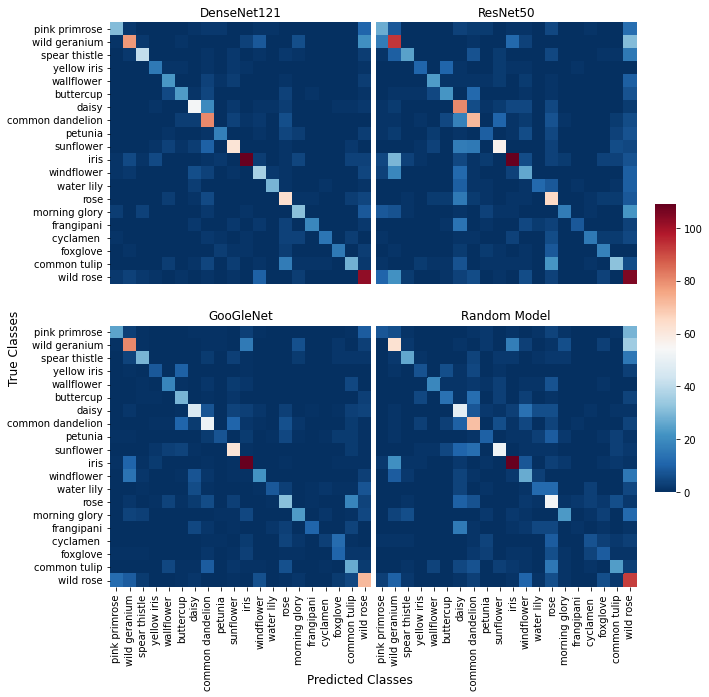

In [ ]:
fig,axn = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 10))
xticks = CLASSES
yticks = CLASSES
ax = plt.subplot(2, 2, 1)
cbar_ax = fig.add_axes([.91, .3, .03, .4])

sns.heatmap(
    conf_matrix_dense, annot=False, cmap='RdBu_r',
    xticklabels=False, yticklabels=yticks, cbar=False, ax=ax)
ax.set_title('DenseNet121')
ax.set_aspect('equal')

ax = plt.subplot(2, 2, 2)
sns.heatmap(
    conf_matrix_res, annot=False, cmap='RdBu_r',
    xticklabels=False, yticklabels=False, cbar=False, ax=ax)
ax.set_title('ResNet50')
ax.set_aspect('equal')

ax = plt.subplot(2, 2, 3)
sns.heatmap(
    conf_matrix_google, annot=False, cmap='RdBu_r',
    xticklabels=xticks, yticklabels=yticks, cbar=False, ax=ax)
ax.set_title('GooGleNet')
ax.set_aspect('equal')

ax = plt.subplot(2, 2, 4)
sns.heatmap(
    conf_matrix_rand, annot=False, cmap='RdBu_r',
    xticklabels=xticks, yticklabels=False, cbar=True, cbar_ax=cbar_ax, ax=ax)
ax.set_title('Random Model')
ax.set_aspect('equal')
fig.text(0.5, 0.04, 'Predicted Classes', ha='center', va='center', fontsize = 12)
fig.text(0.02, 0.5, 'True Classes', ha='center', va='center', rotation='vertical', fontsize = 12)
fig.tight_layout(rect=[0, 0, .9, 1])

In [ ]:
# fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize = (20, 10))
# # sns.set(rc = {'figure.figsize':(20,8)})
# # sns.set(font_scale=1.1)
# sns.heatmap(conf_matrix_dense, annot = False, fmt='g', xticklabels=CLASSES, yticklabels=CLASSES, ax = ax1)
# sns.heatmap(conf_matrix_res, annot = False, fmt='g', xticklabels=CLASSES, yticklabels=CLASSES, ax = ax2)
# sns.heatmap(conf_matrix_google, annot = False, fmt='g', xticklabels=CLASSES, yticklabels=CLASSES, ax = ax3)
# sns.heatmap(conf_matrix_rand, annot = False, fmt='g', xticklabels=CLASSES, yticklabels=CLASSES, ax = ax4)
# sns.heatmap(conf_matrix_base, annot = False, fmt='g', xticklabels=CLASSES, yticklabels=CLASSES, ax = ax5)
# # ax.set_title('Confusion  Matrix', fontdict = {'fontsize' : 15})
# plt.show()

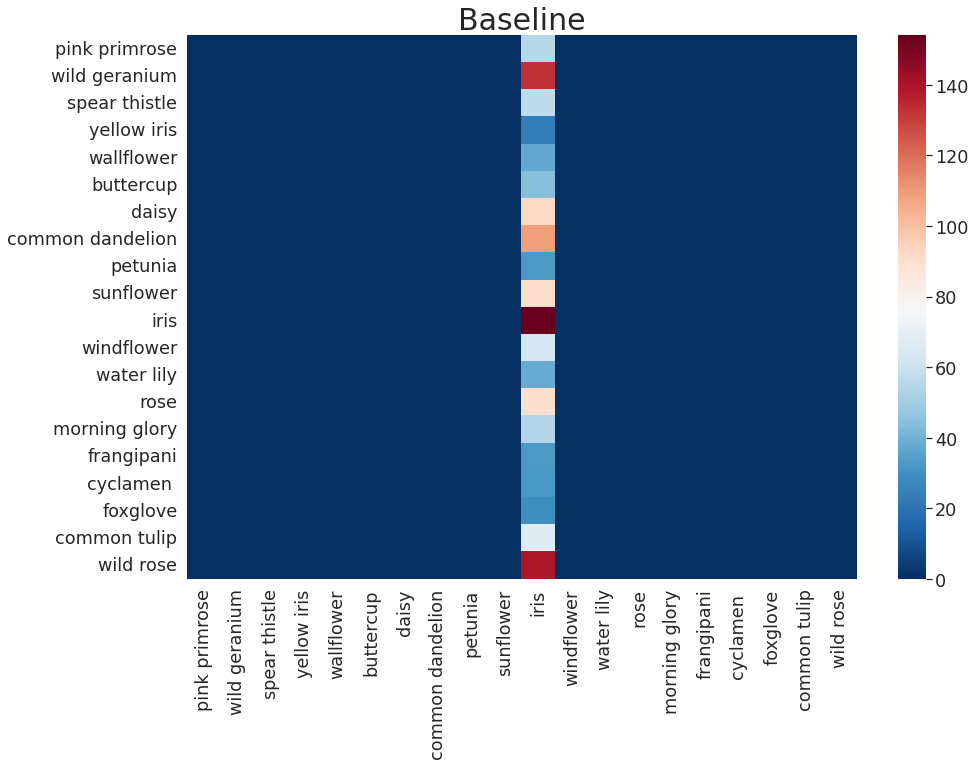

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (15, 10))
sns.set(rc = {'figure.figsize':(20,8)})
sns.set(font_scale=1.6)
sns.heatmap(conf_matrix_base, annot = False, fmt='g', xticklabels=CLASSES, yticklabels=CLASSES, ax = ax, cmap='RdBu_r')

ax.set_title('Baseline', fontdict = {'fontsize' : 30})
plt.show()